# Benchmarking the MPS code

Here we benchmark our MPS reuslts (TEBD and TDVP) with respect to our existing exact diagonalaization data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import h5py
import json
import matplotlib 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys  

from ast import literal_eval

from qutip import  *

sys.path.append('../../scripts') 

from qutip_tools import *


/Users/rasputin/Desktop/Uni/PhD/hoping_chain_tensors/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/rasputin/Desktop/Uni/PhD/hoping_chain_tensors/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# define basic figure sizes
bwidth=7
bheight=5
base_font = 21

matplotlib.rcParams.update({'font.size': base_font,"legend.fontsize":base_font-4 ,"font.family": "serif", 
                            "font.serif": "CMU Serif, Times New Roman",
                           'text.usetex' : True })

sns.set_palette("colorblind")

fig_route = "../../plots/benchmark_mps/"


In [3]:
J=1
om_ = 0.7

In [4]:
data_route = "../../data/sims/L=21/"
MPS_route= "../../data/MPS/L=21/"

# names for exact diag
file_list = get_file_names_on(["bw2.0","om{}_".format(om_),"dd0fixed", "k1.5708", "t0.1"], data_route)
file_name = file_list[0]
file_list

['res_L21_maxtim18.0_bw2.0_k1.5708_jp1.0_t0.1_om0.7_dd0fixed.hdf5']

In [5]:
# names for TEBD
file_list = get_file_names_on(["Del2.0", "om{}".format(om_), "free", "k1.571", "t0.1","theta3.142","phi-1.571"], MPS_route)
TEBD_file = file_list[0]

file_list


['TEBD_L21_J1.0_t0.1_om0.7_Del2.0_k1.571_bindex8_maxtau18_cutoff-18_free_theta3.142_phi-1.571.h5']

In [6]:
# load exact diagonalization
param_dict, times, n_bond, n_left, n_right, n_d1, n_d2, traject, VN_entropy, purity, dd_theta , dd_phi = load_data(data_route,file_name)

# load TEBd
TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS(MPS_route, TEBD_file)   

10.5 1.5707963267948966
phi is undefined using next values
10.5 1.5707963267948966


# Functions

In [7]:
def interpolate_short_array(b,a):
    # In order to compare arrays b and a of different length we
    # interpolate the shortest (b) to match the length of a
    # this makes sense only if a and b start and end at the "same place" but are
    # sampled at different rates
    
    return  np.interp(np.linspace(0, len(b) - 1, len(a)), np.arange(len(b)),b)
    

# Rabi Oscillations

In [8]:
TEBD_d1 = TEBD_occ[:,-2]
TEBD_d2 = TEBD_occ[:,-1]


d1_interpol = interpolate_short_array(TEBD_d1,n_d1)

Err2 = (d1_interpol- n_d1)**2


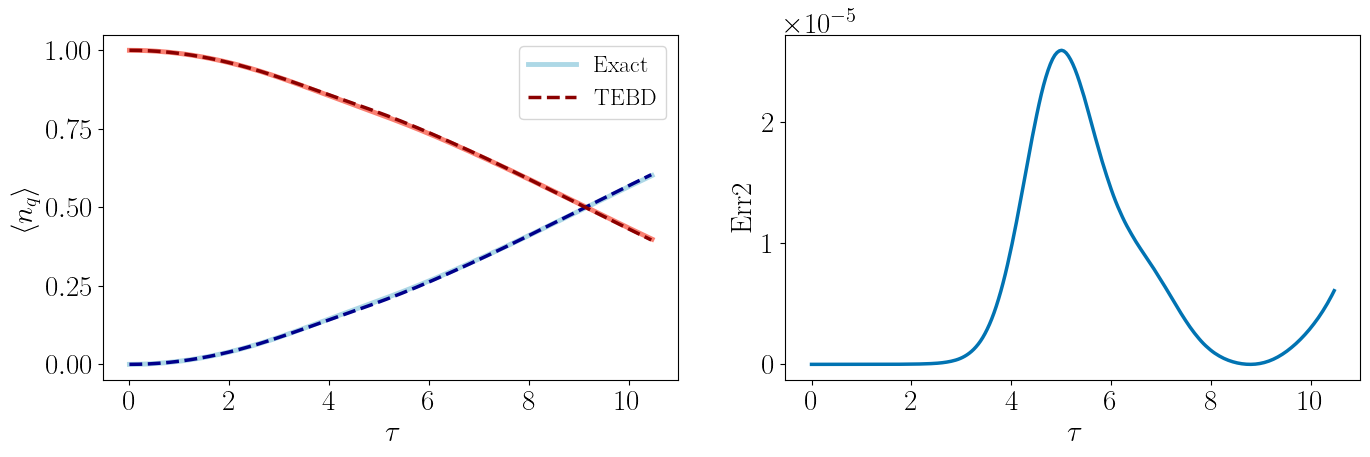

In [9]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight))

ax[0].plot(times, n_d1, c="lightblue", linewidth=3.5, label="Exact")
ax[0].plot(times, n_d2, c="salmon",linewidth=3.5)
ax[0].plot(TEBD_times, TEBD_d1, linestyle="dashed",linewidth=2.5, c="darkblue")
ax[0].plot(TEBD_times, TEBD_d2, linestyle="dashed",linewidth=2.5, c="darkred", label="TEBD")

ax[1].plot(times, Err2,linewidth=2.5)

ax[0].set_ylabel(r"$\langle n_q \rangle$")
ax[0].set_xlabel(r"$\tau$")
ax[1].set_ylabel(r"Err2")
ax[1].set_xlabel(r"$\tau$")


ax[0].legend()

plt.tight_layout()


plt.savefig(fig_route+"rabi_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))


# Transmission/Reflection coefficients

In [10]:
TEBD_bindex = TEBD_params["bond_index"] -1  # because of Julia indexing
TEBD_R = np.sum(TEBD_occ[:,:TEBD_bindex-1],axis=1)
TEBD_T = np.sum(TEBD_occ[:,TEBD_bindex+1:-2],axis=1)
TEBD_Bond = np.sum(TEBD_occ[:,TEBD_bindex-1:TEBD_bindex+1],axis=1)


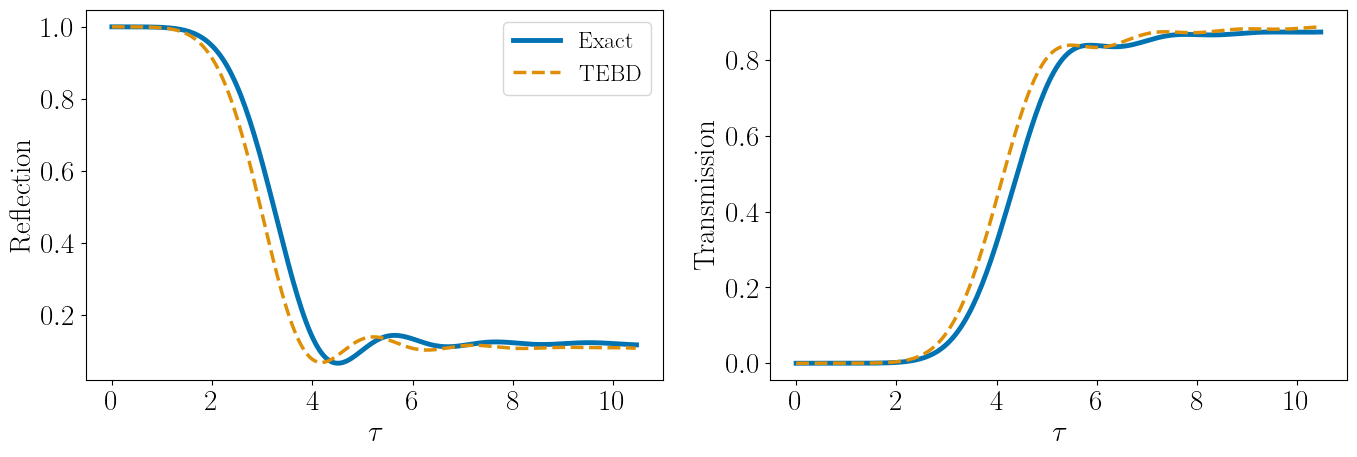

In [11]:
fig, ax = plt.subplots(1,2 , figsize=(2*bwidth,bheight))

ax[0].plot(times, n_left, linewidth=3.5, label="Exact")
ax[0].plot(TEBD_times, TEBD_R, linewidth=2.5, label="TEBD", linestyle="dashed")


ax[1].plot(times, n_right, linewidth=3.5)
ax[1].plot(TEBD_times, TEBD_T, linewidth=2.5, linestyle="dashed")


ax[0].set_ylabel(r"Reflection ")
ax[0].set_xlabel(r"$\tau$")
ax[1].set_ylabel(r"Transmission ")
ax[1].set_xlabel(r"$\tau$")
ax[0].legend()

plt.tight_layout()


plt.savefig(fig_route+"QPC_coeffs_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))


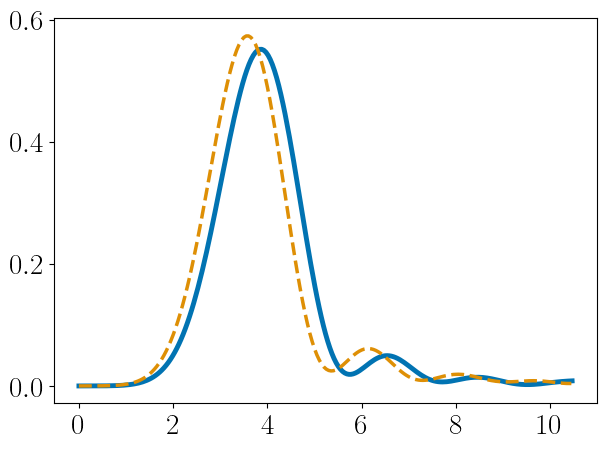

In [12]:
# bond density
fig, ax = plt.subplots(1,1 , figsize=(bwidth,bheight))
ax.plot(times, n_bond, linewidth=3.5, label="Exact")
ax.plot(TEBD_times, TEBD_Bond, linewidth=2.5, label="TEBD", linestyle="dashed")


# Entropy

In [13]:
# this time is the exact entropy the one we sample less
Entropy_interpol = interpolate_short_array(VN_entropy, TEBD_entropies)

Entropy_Err2 = (TEBD_entropies- Entropy_interpol)**2



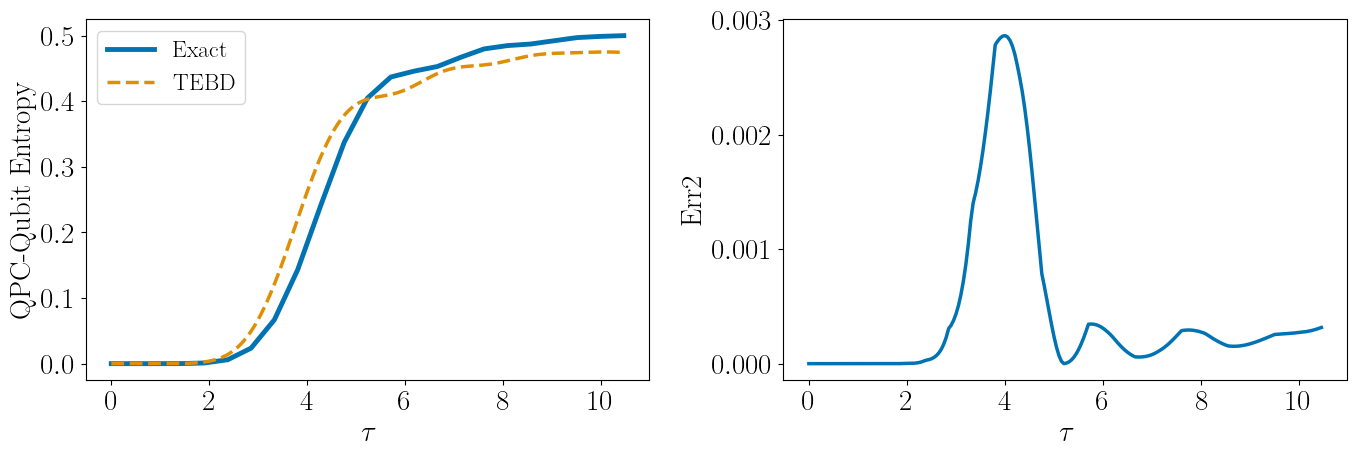

In [14]:
fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight))

# since we dont calculate the entropy at each time
times_coarse = np.linspace(times[0], times[-1], len(VN_entropy))

# divide by singlet entropy
ax[0].plot(times_coarse, VN_entropy/np.log(2), linewidth=3.5,label="Exact")
ax[0].plot(TEBD_times ,TEBD_entropies/np.log(2),linewidth=2.5, linestyle="dashed", label="TEBD")

ax[0].set_ylabel(r"QPC-Qubit Entropy")
ax[0].set_xlabel(r"$\tau$")
ax[0].legend()

ax[1].plot(TEBD_times, Entropy_Err2, linewidth=2.5,label="Exact")
ax[1].set_ylabel(r"Err2")
ax[1].set_xlabel(r"$\tau$")

plt.tight_layout()

plt.savefig(fig_route+"entropy_L={}_tdot={}_K={}_bw={}_Jp={}_om={}.pdf".format(
            param_dict["L_qpc"], param_dict["t"], param_dict["k0"], param_dict["band_width"],
            param_dict["J_prime"], param_dict["Omega"]))


# Bloch Sphere

# Growth of Bond Dimension

How much does the Bond dimension grow with $\Omega$ and $t$

In [15]:
# names for TEBD
file_list = get_file_names_on(["Del2.0", "free", "k1.571", "t0.1","theta3.142","phi-1.571"], MPS_route)
# TEBD_file = file_list
file_list

['TEBD_L21_J1.0_t0.1_om0.7_Del2.0_k1.571_bindex8_maxtau18_cutoff-18_free_theta3.142_phi-1.571.h5',
 'TEBD_L21_J1.0_t0.1_om0.5_Del2.0_k1.571_bindex8_maxtau18_cutoff-18_free_theta3.142_phi-1.571.h5',
 'TEBD_L21_J1.0_t0.1_om0.1_Del2.0_k1.571_bindex8_maxtau18_cutoff-18_free_theta3.142_phi-1.571.h5',
 'TEBD_L21_J1.0_t0.1_om0.0_Del2.0_k1.571_bindex8_maxtau18_cutoff-18_free_theta3.142_phi-1.571.h5']

10.5 1.5707963267948966
10.5 1.5707963267948966
10.5 1.5707963267948966
10.5 1.5707963267948966


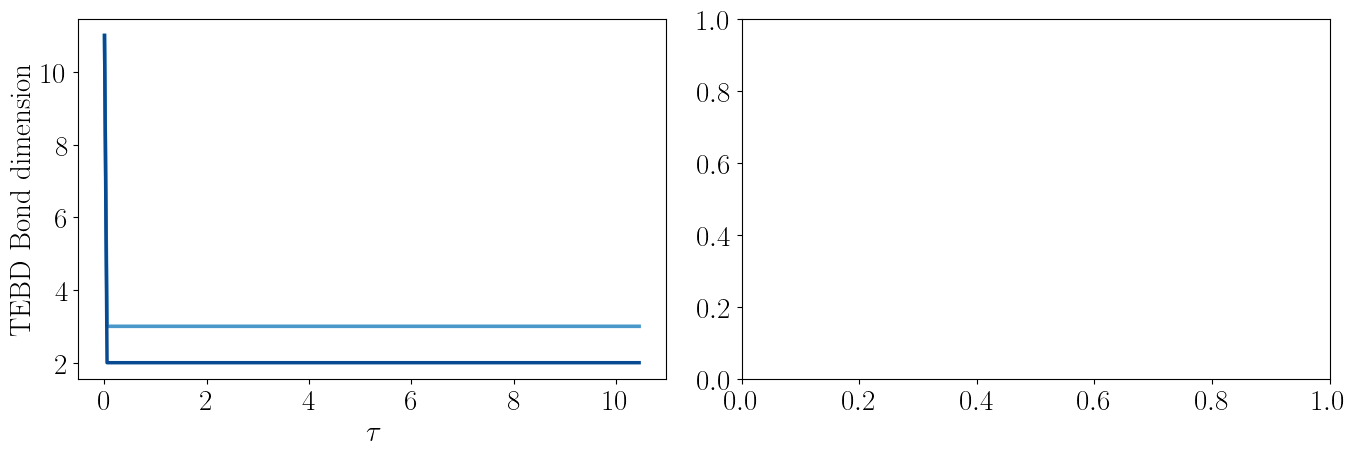

In [25]:
colors = plt.cm.Blues(np.linspace(0.0,0.9,len(file_list)))

fig, ax = plt.subplots(1,2, figsize=(2*bwidth,bheight))

for i in range(0,len(file_list)):
    TEBD_file = file_list[i]
    TEBD_params, TEBD_times, TEBD_occ, TEBD_bond_dim, TEBD_entropies, TEBD_qubit_rho  = load_MPS(MPS_route, TEBD_file) 

    ax[0].plot(TEBD_times, TEBD_bond_dim, c = colors[i],linewidth=2.5)

ax[0].set_ylabel(r"TEBD Bond dimension")
ax[0].set_xlabel(r"$\tau$")

plt.tight_layout()
